In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import math, time

from scipy.ndimage import zoom
from scipy.ndimage.interpolation import rotate as rot3d
from scipy.ndimage import binary_closing
from scipy.ndimage import generate_binary_structure

import cv2, os

In [2]:
def nii2pano(path):
    img = nib.load(path)
    
    return np.array(img.dataobj)

In [3]:
def making_arc(sum_, curv, x_vertex, y_vertex, start_x, range_m, range_p, mode): # (volume, radius of curvature, x_coordinate of vertex, y_coordinate of vertex)
    
    #####################
    ## drawing Ellipse ##
    #####################
    
    ## make parabola function and apply to projected 2d ct image
#     a = 0.003
#     b = 690
#     c = 1000
    
    a = curv
    b = x_vertex
    c = y_vertex
    
#     sum_ = np.sum(res1, axis=2)
    
    # find arc
    ## x, y meshgrid
    x = np.zeros((sum_.shape[0], sum_.shape[1]))
    y = np.zeros((sum_.shape[0], sum_.shape[1]))

    for w in range(x.shape[0]):
        for h in range(x.shape[1]):
            x[w,h] = h
            y[w,h] = w      

    tmp = abs(-a*(y-b)**2+c-x)
    tmp_ = np.where(tmp < 1, sum_.max()+100, sum_)
    
    p=start_x
    q=round(math.sqrt(-(p-c)/a)+b) 

    # x와 y 변화량
    delta_x = 1
    delta_y = 0
    i=1

    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) 
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
    p_indx = indx[0][0]
    print(p_indx)
    
    tmp_m = abs(g*(y-q)+p-x)
    tmp_r_m = np.where(tmp_m < 1, tmp_.max() , tmp_)
    rot_tmp_m = rot3d(tmp_r_m, angle, axes=(1,0), reshape=False) 
    sum_rot_tmp_m = np.sum(rot_tmp_m, axis=1)
    indx_m = np.where(sum_rot_tmp_m == sum_rot_tmp_m.max())
    p_indx_m = indx_m[0][0]
    print(p_indx_m)
    
    if mode == 0 :
        line = np.zeros((sum_.shape[0], sum_.shape[1]))
        line[:, p_indx] = 1
        rot_line = rot3d(line, -angle, axes=(1,0), reshape=False)
                    
    elif mode == 1:
        print('mode 1 activated')
        line = np.zeros((sum_.shape[0], sum_.shape[1]))
        line[p_indx_m-range_m:p_indx_m+range_p, p_indx] = 1
        print(line[p_indx_m, p_indx])
        rot_line = rot3d(line, -angle, axes=(1,0), reshape=False)      
    
    else :
        pass

    return tmp_r, (rot_line*sum_.max())+sum_

In [4]:
def visualize(nii):
    sagittal = np.sum(nii, axis=0)
    coronal = np.sum(nii, axis=1)
    axial = np.sum(nii, axis=2)

    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.imshow(np.rot90(sagittal), cmap='gray')

    plt.subplot(132)
    plt.imshow(np.rot90(coronal), cmap='gray')

    plt.subplot(133)
    plt.imshow(axial, cmap='gray')

___
## [Load CT]
___

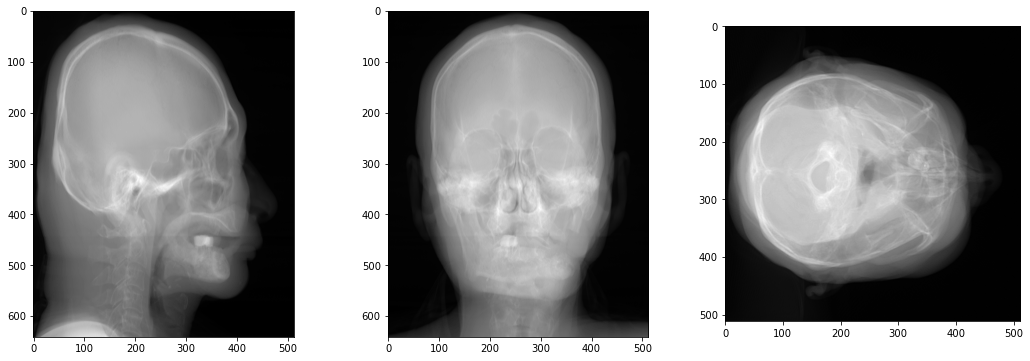

In [6]:
# nii = nii2pano("/ryan/project/ct2pano/Data/nifti/P00824721/SR600936G_1_02_3D_Facial_20190814144657_2.nii")
# p_num = 'P00824721'
# print(nii.shape)
# visualize(nii)

nii = nii2pano("/ryan/project/ct2pano/Data/nifti/P00298617/SR600936G_1_02_3D_Facial_20191016131808_2.nii")
p_num = 'P00298617'
visualize(nii)

(450, 450, 260)


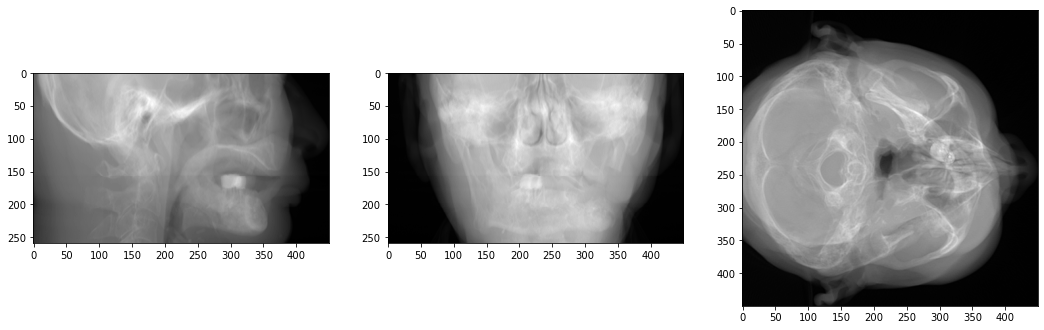

In [10]:
sam = nii[20:470, 30:480, 95:355]
print(sam.shape)

visualize(sam)

-0.004712575999999996
0.8379319539999999


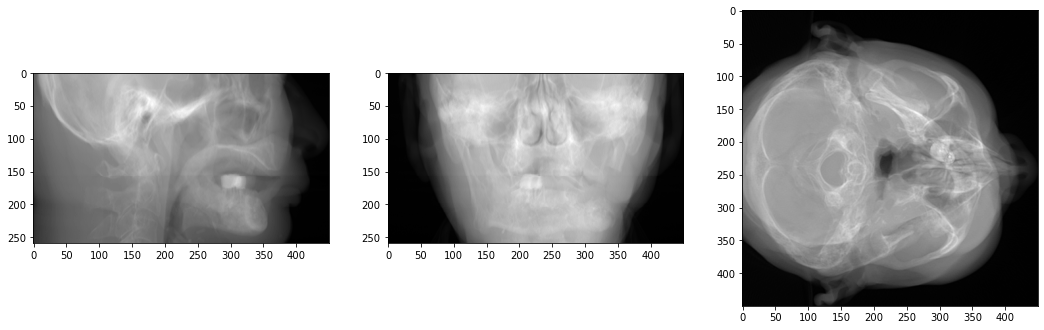

In [13]:
# convert HU to LAC #

mu = (sam*(2.06E-01-2.26E-04)/1000)+2.06E-01
print(mu.min())
print(mu.max())
# visualize(mu)

visualize(mu)

-0.004712575999999996
0.8379319539999999
-0.010892341592445755
5.860884413217047


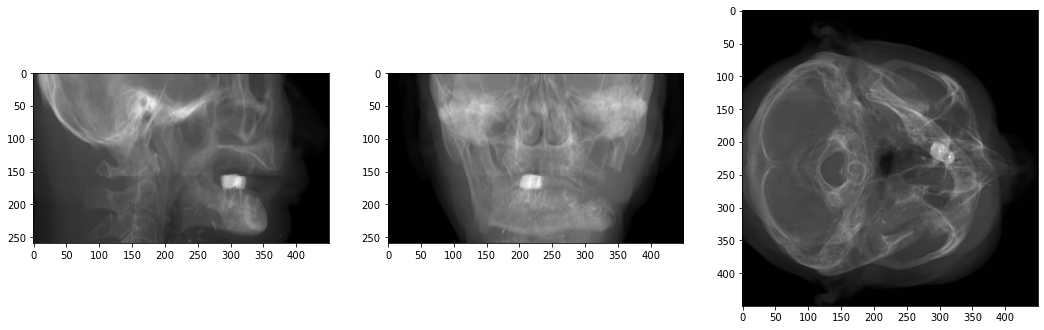

In [14]:
# LAC conversions, 60keV to 30keV #

# mu = np.where(mu<0, 0, mu)
print(mu.min())
print(mu.max())

pano_map = np.where(mu<0.8, 4.7723*(mu**4)-14.45*(mu**3)+15.362*(mu**2)-0.8329*mu+0.0007, 0.0364*(mu**2)+2.985*mu+3.3341)

print(pano_map.min())
print(pano_map.max())
visualize(pano_map)

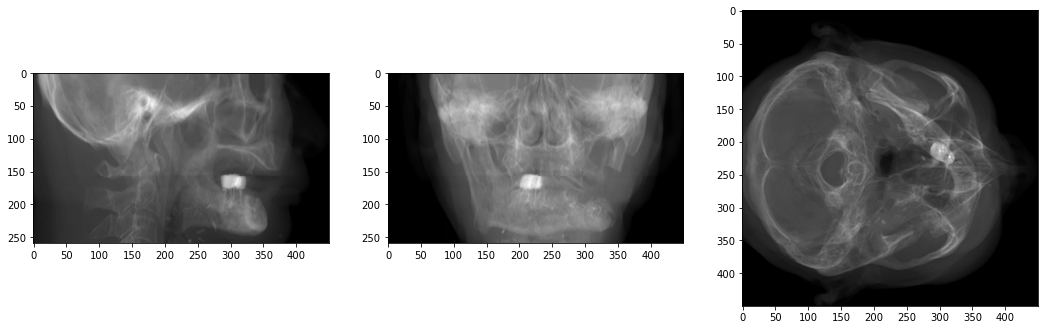

In [15]:
# res1 = zoom(pano_map, (2,2,2))
res1 = pano_map

# zero-clipping #
res1 =np.where(res1<0, 0, res1)

visualize(res1)

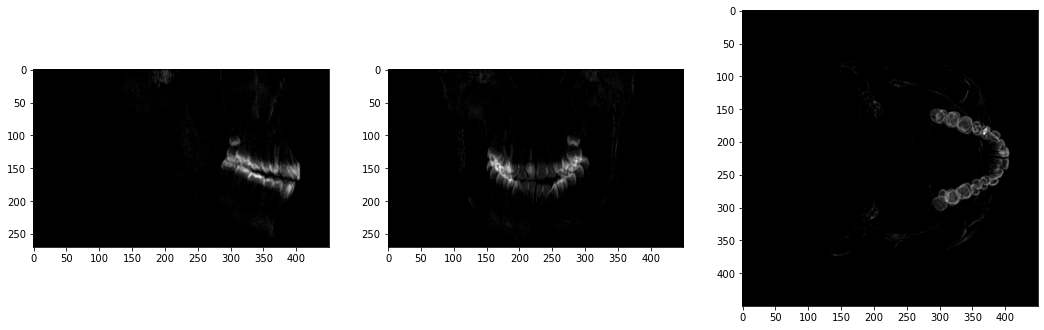

In [183]:
res1 = pano_map

# binarize LAC, based on bone's LAC value #
mu_t = 2.7
res1 =np.where(res1<mu_t, 0, 1)

visualize(res1)

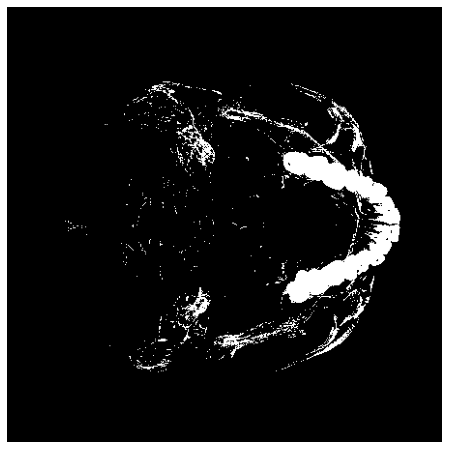

In [164]:
axial = np.sum(res1, axis=2)
axial = np.where(axial<1, 0, 1)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(axial, cmap='gray')
plt.savefig("/ryan/project/ct2pano/Data_new/figures/image_generate_process/new_morp_02.png", dpi=300)

___
## [Finding dental arch : Morphology thinning]
___

In [165]:
from skimage.morphology import closing
from skimage.morphology import opening
from skimage.morphology import square
from skimage.morphology import skeletonize

from skimage.morphology import erosion
from skimage.morphology import dilation

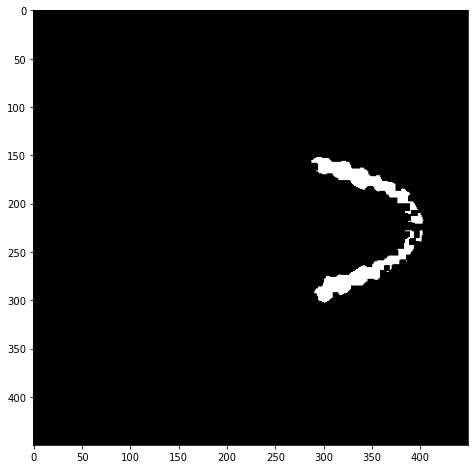

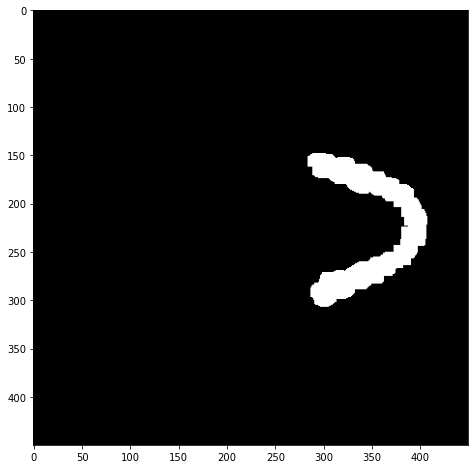

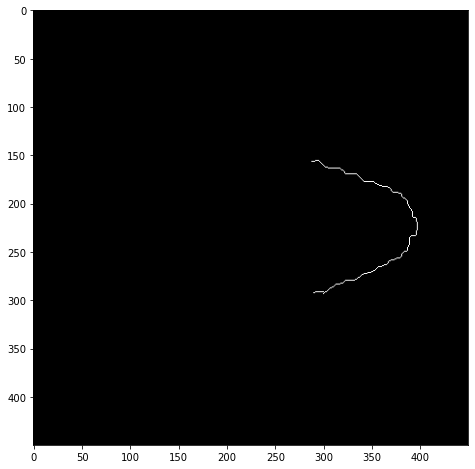

In [166]:
# Morphology methods #

morp_axial = erosion(axial, selem=square(6))
plt.figure(figsize=(8,8))
# plt.axis("off")
plt.imshow(morp_axial, cmap='gray')
plt.show()

morp_axial = dilation(morp_axial, selem=square(9))
plt.figure(figsize=(8,8))
# plt.axis("off")
plt.imshow(morp_axial, cmap='gray')

plt.show()


morp_axial = skeletonize(morp_axial)
plt.figure(figsize=(8,8))
# plt.axis("off")
plt.imshow(morp_axial, cmap='gray')
plt.show()

In [170]:
a = 0.020
b =225
c=397
x = np.zeros((morp_axial.shape[0], morp_axial.shape[1]))
y = np.zeros((morp_axial.shape[0], morp_axial.shape[1]))

for w in range(x.shape[0]):
    for h in range(x.shape[1]):
        x[w,h] = h
        y[w,h] = w      

tmp = abs(-a*(y-b)**2+c-x)
tmp_ = np.where(tmp < 1, morp_axial.max(), 0)

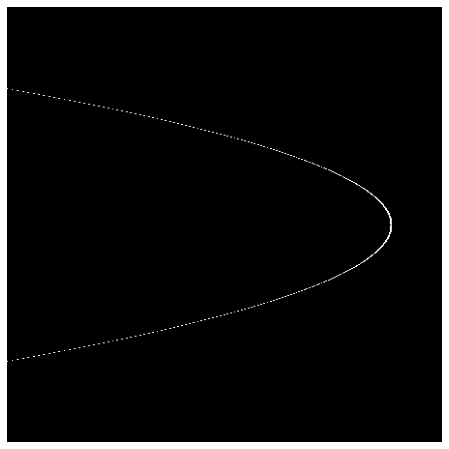

In [171]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(tmp_, cmap='gray')
# plt.savefig("/ryan/project/ct2pano/Data_new/figures/image_generate_process/new_morp_parabola_curve.png", dpi=300)
plt.show()

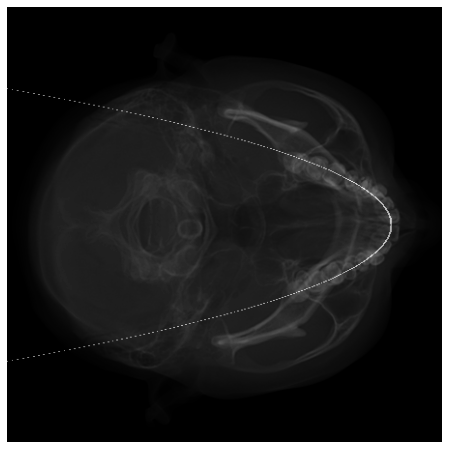

In [179]:
axial = np.sum(res1, axis=2)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(tmp_*500+axial, cmap='gray')
# plt.savefig("/ryan/project/ct2pano/Data_new/figures/image_generate_process/new_morp_curve+2d.png", dpi=300)
plt.show()

(450, 450)
295
125
mode 1 activated
0.0
295
149
mode 1 activated
0.0


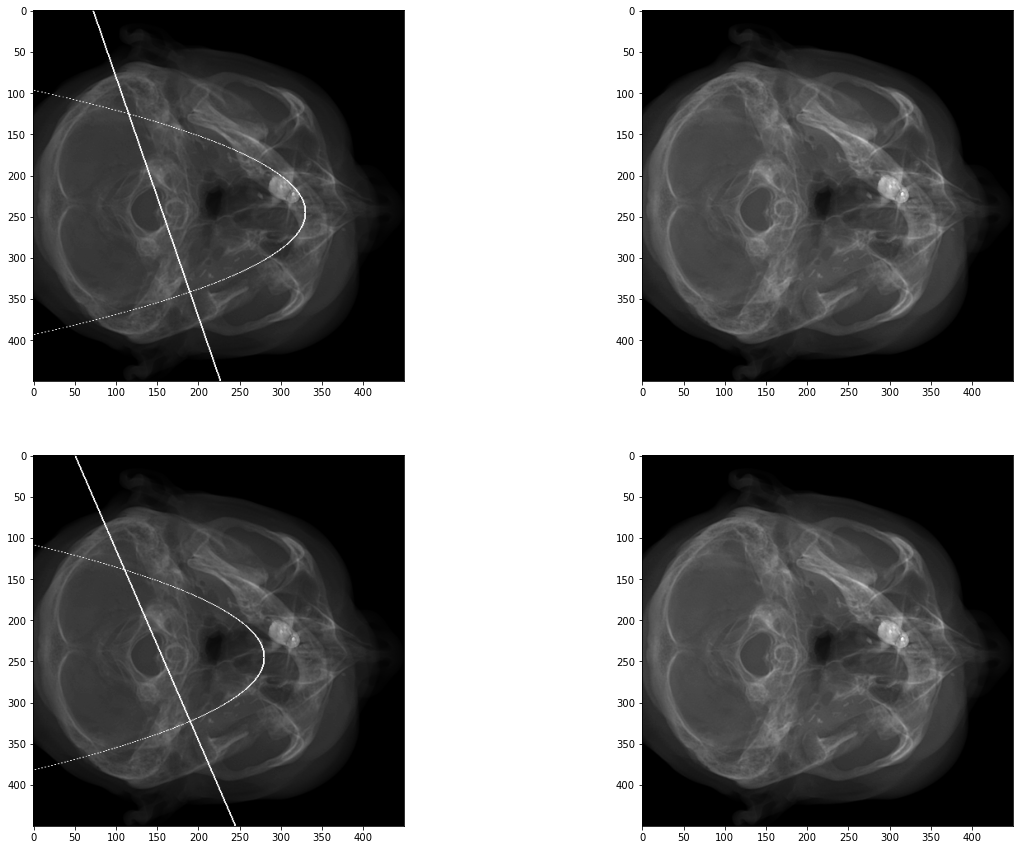

In [20]:
sum_ = np.sum(res1, axis=2)
print(sum_.shape)

arc1, rot_line1 = making_arc(sum_, 0.015, 245, 330, 190, 200, 130, mode=1)
arc2, rot_line2 = making_arc(sum_, 0.015, 245, 280, 190, 200, 130, mode=1)

plt.figure(figsize=(20,15))
plt.subplot(221)
plt.imshow(arc1, cmap='gray')

plt.subplot(222)
plt.imshow(rot_line1, cmap='gray')

plt.subplot(223)
plt.imshow(arc2, cmap='gray')

plt.subplot(224)
plt.imshow(rot_line2, cmap='gray')

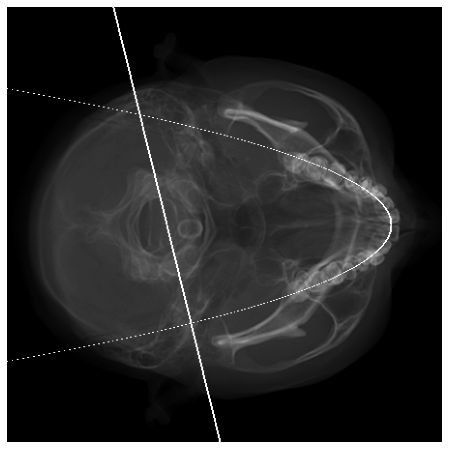

In [17]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(arc1, cmap='gray')
plt.show()

___
## [Generating...]
___

Takes 6.313035249710083 seconds for 1 loop
Takes 6.311831474304199 seconds for 1 loop
Takes 6.306949853897095 seconds for 1 loop
Takes 6.302919626235962 seconds for 1 loop
======  20 th =====


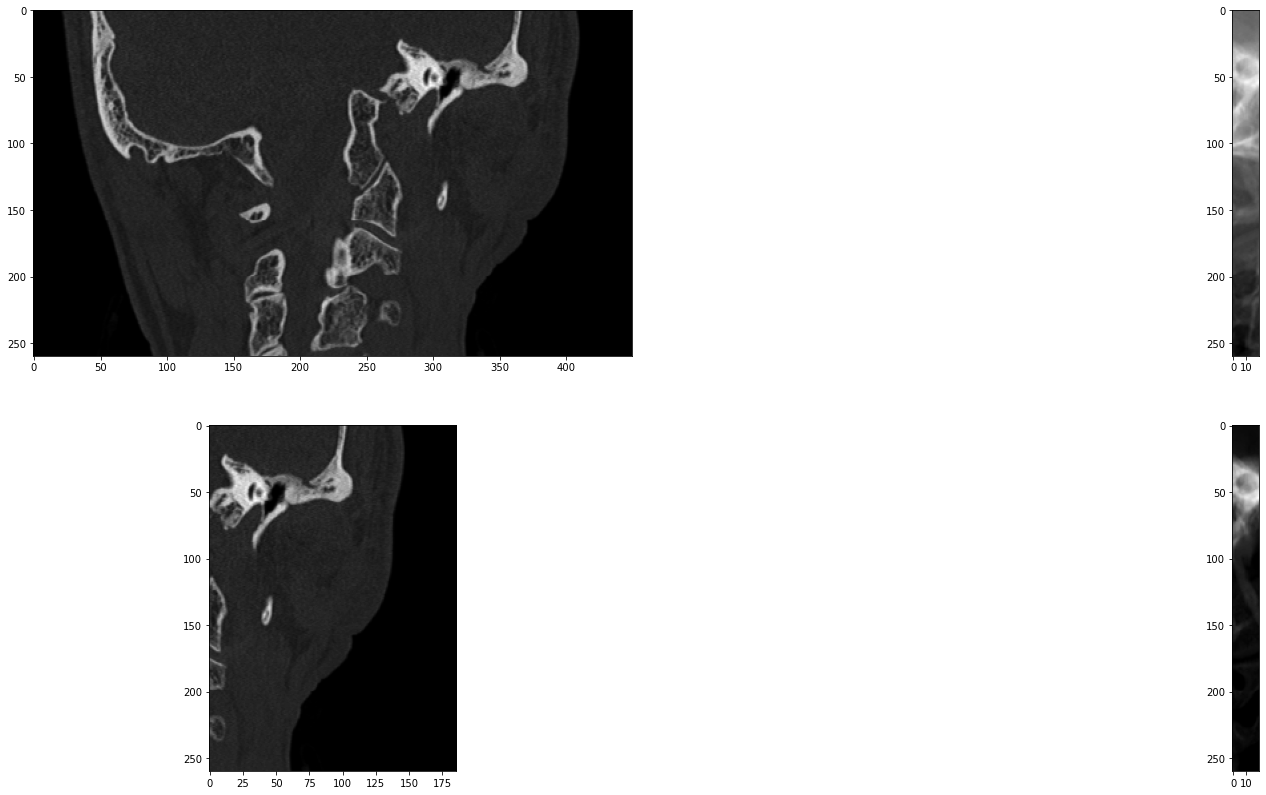

======  40 th =====


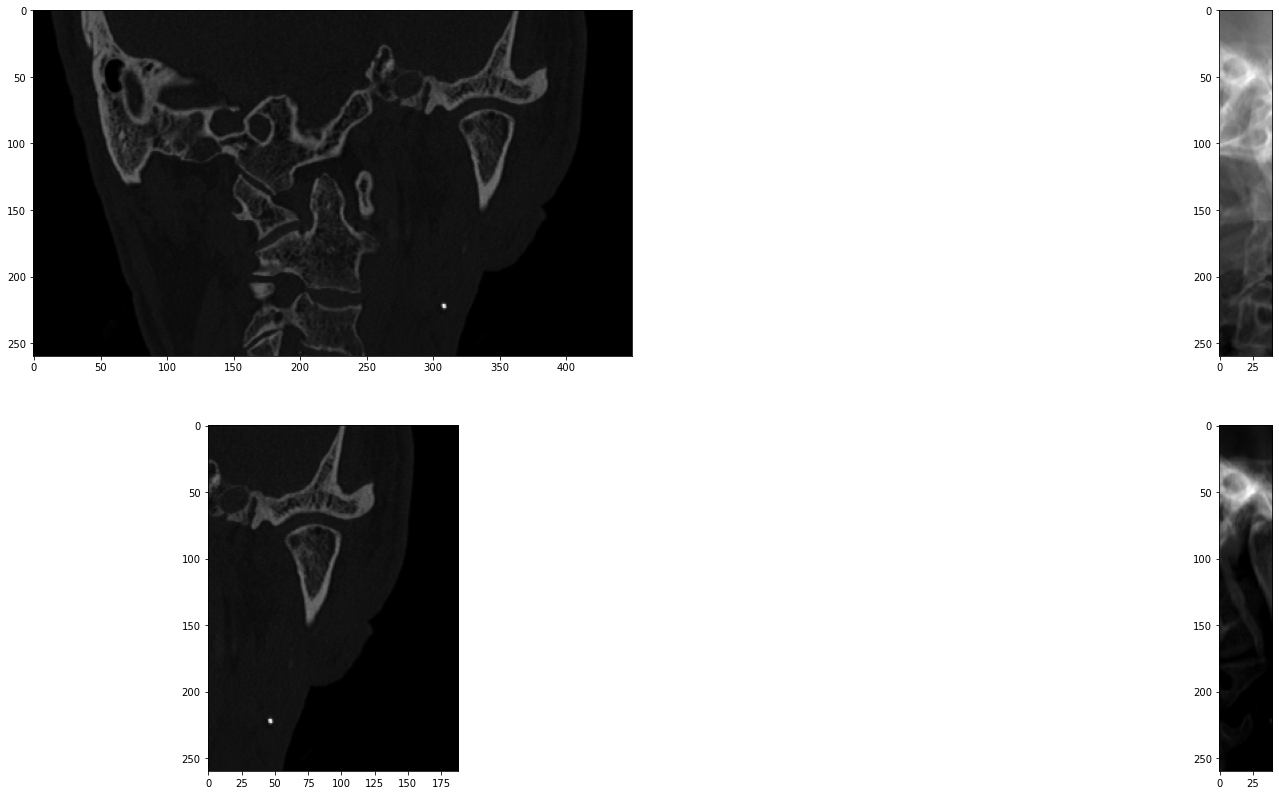

======  60 th =====


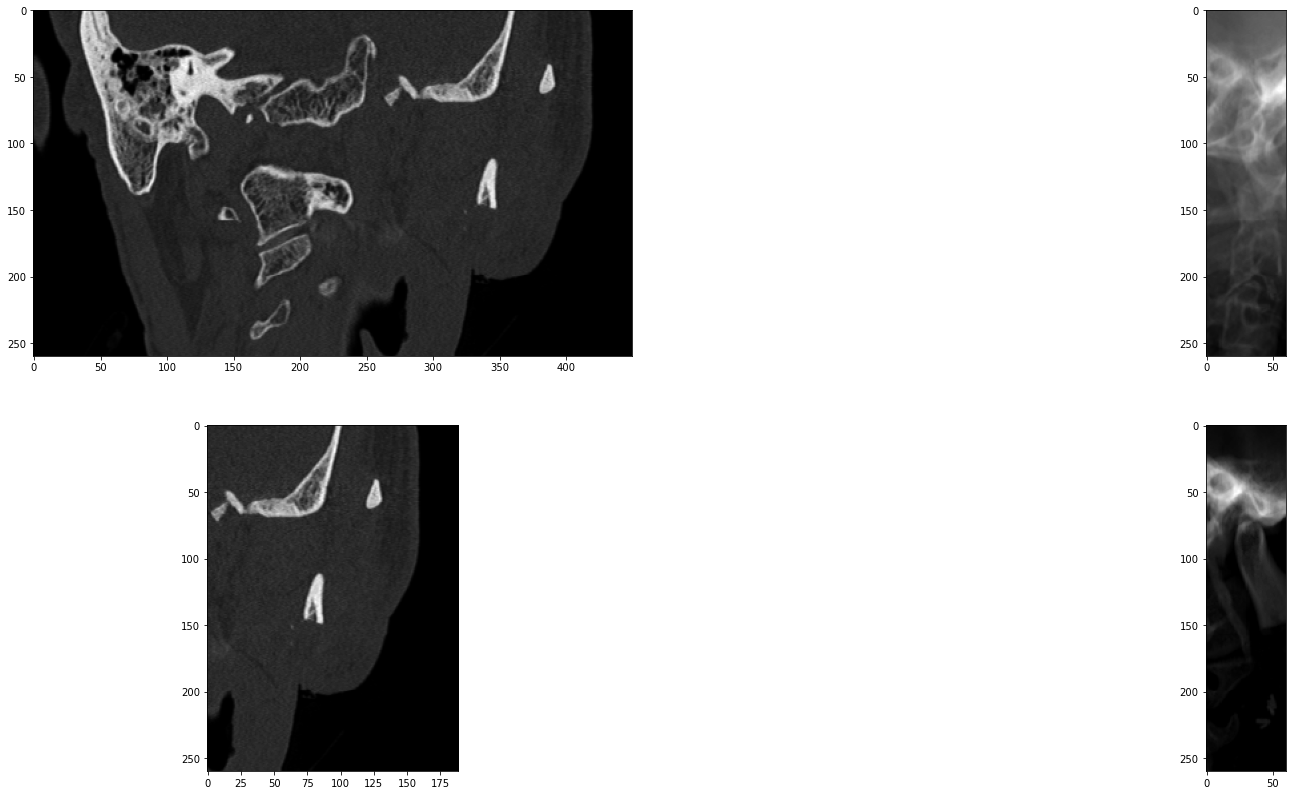

======  80 th =====


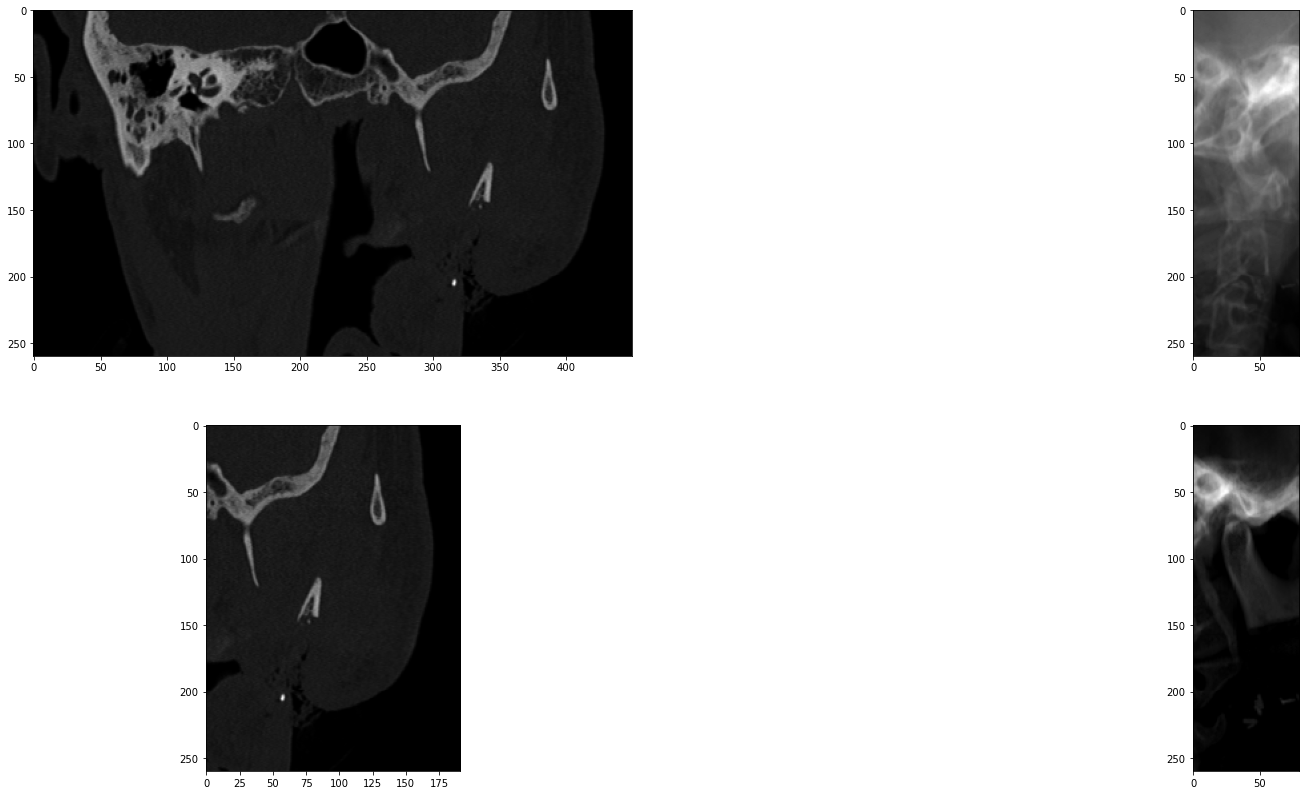

======  100 th =====


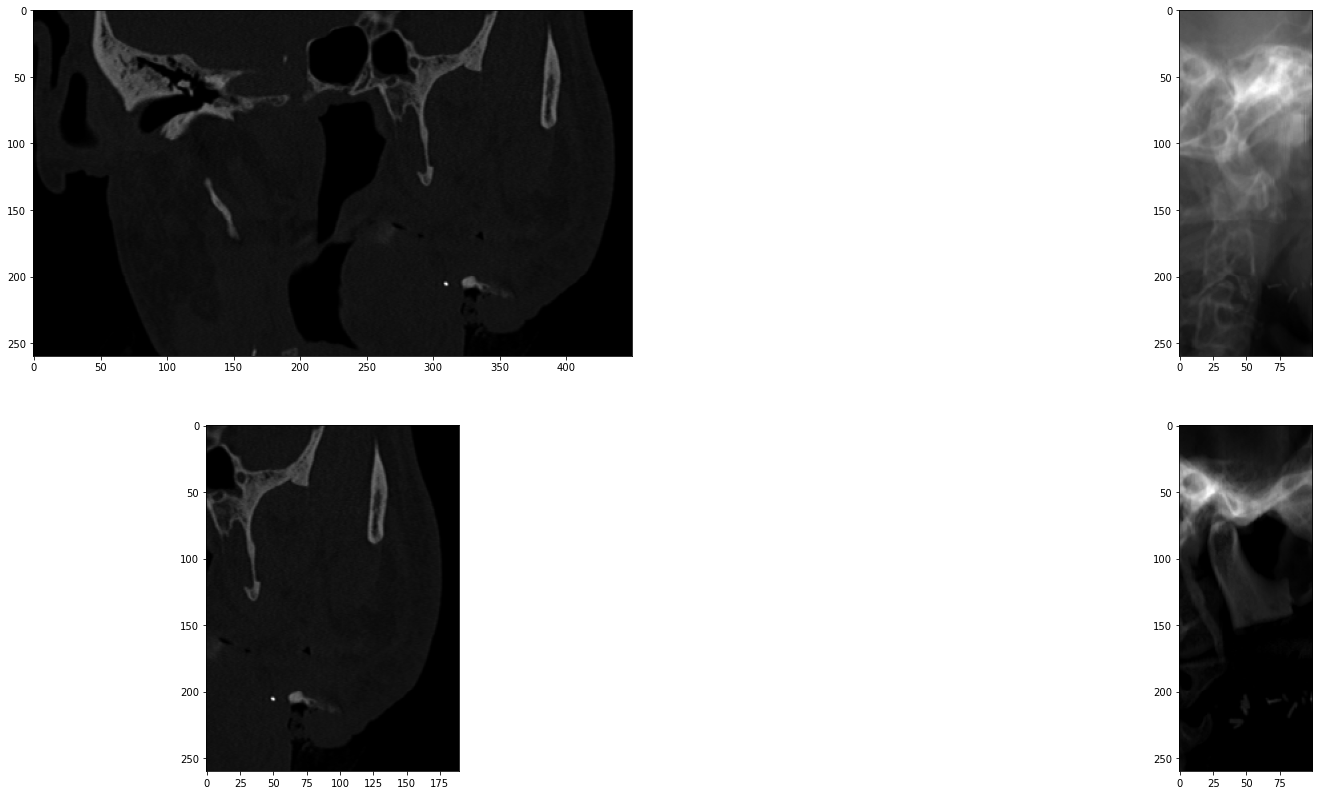

======  120 th =====


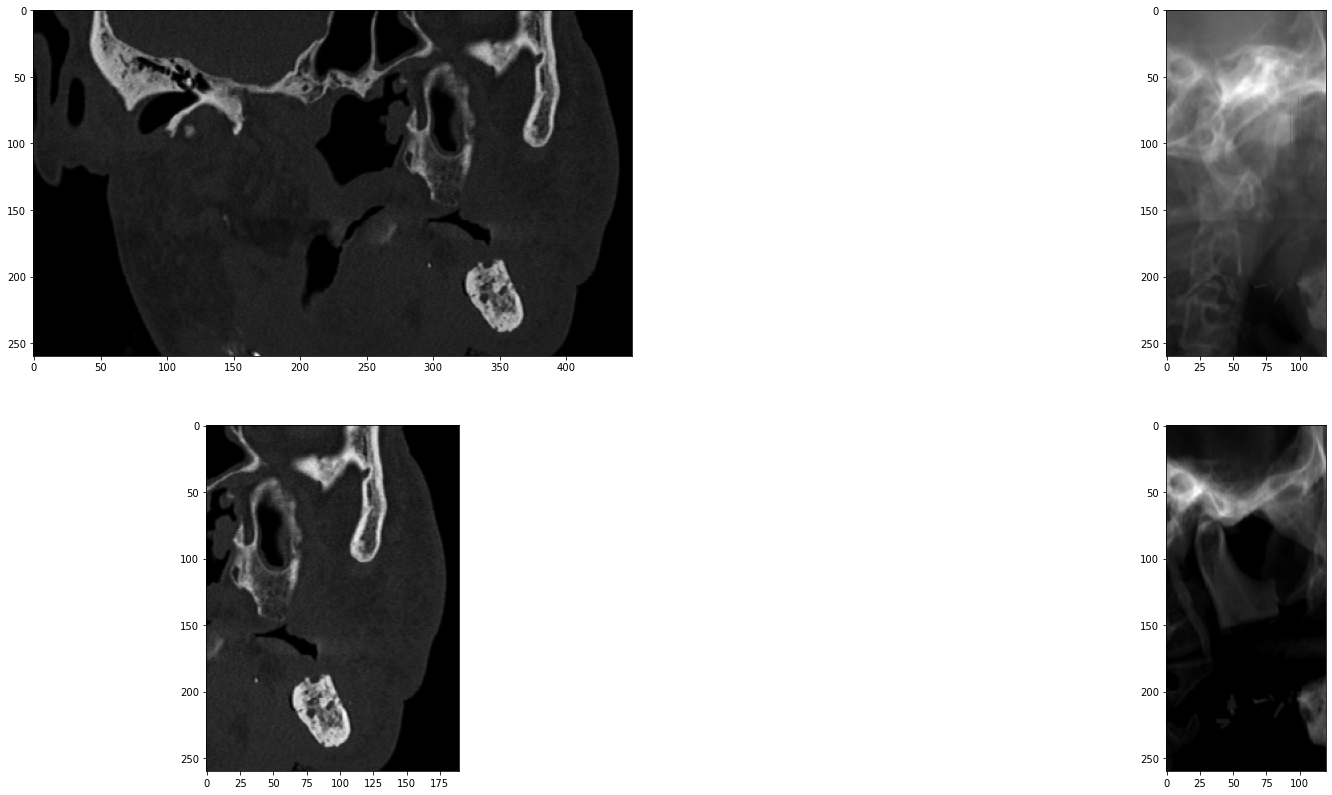

======  140 th =====


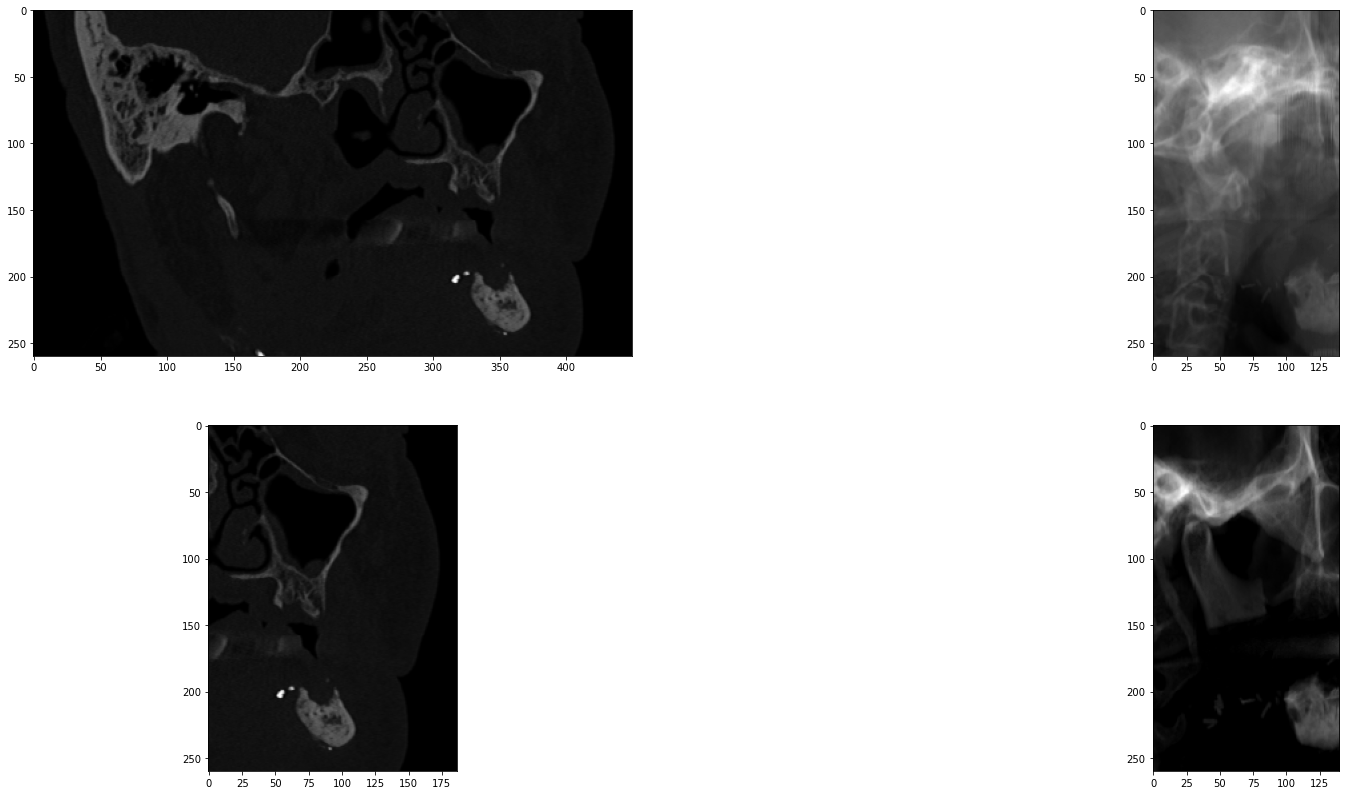

q :  274 opp_q :  216
=================== 조건 q>=b =======================
======  160 th =====


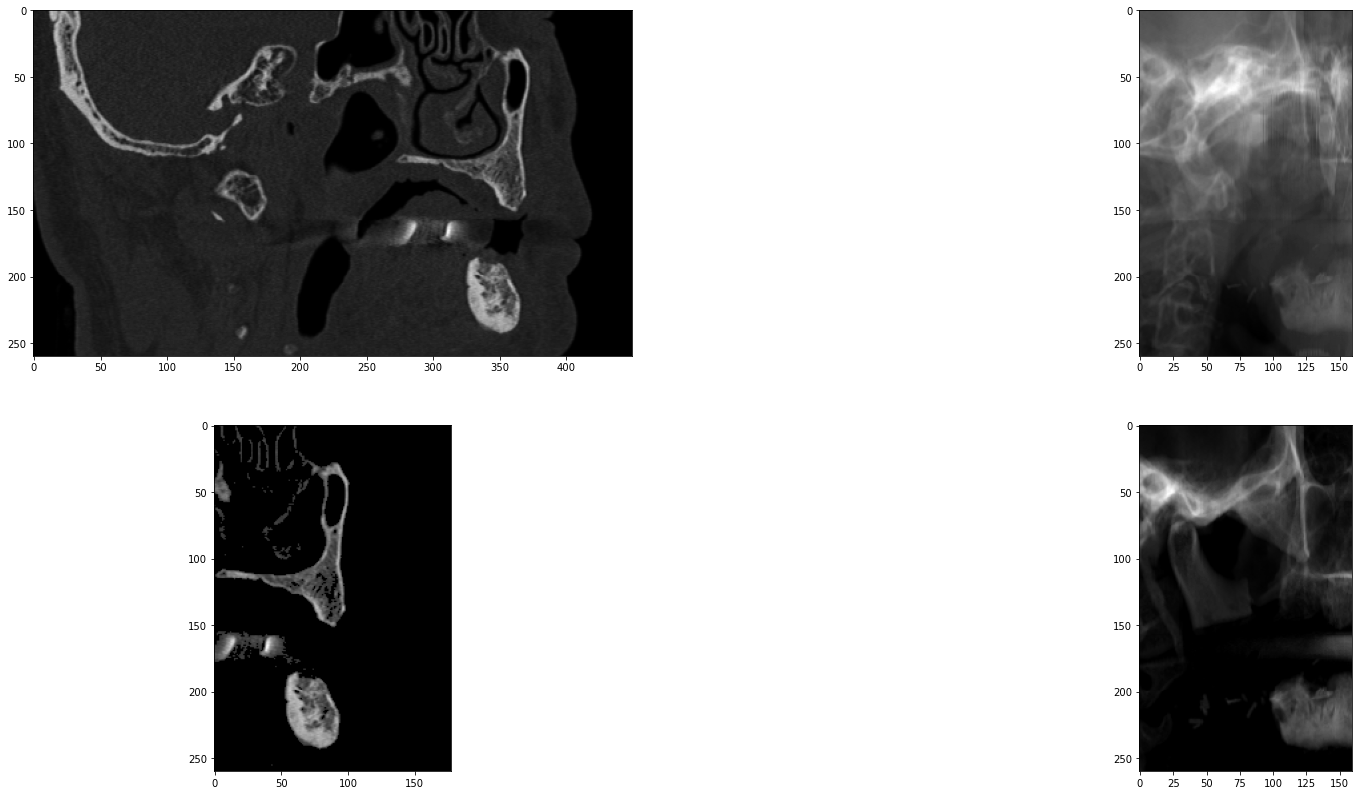

============ 조건 (q>=opp_q) and (delta_x<=delta_y) ===============
======  180 th =====


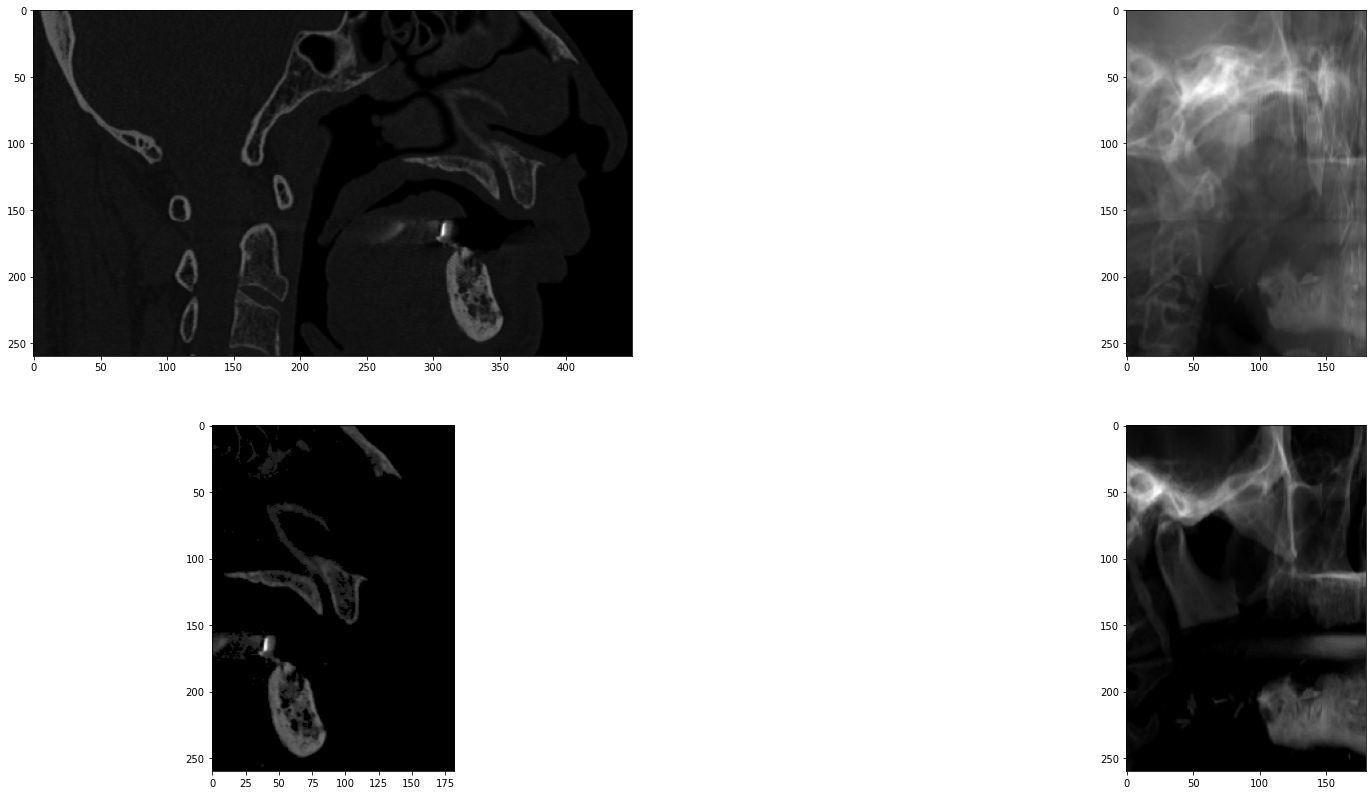

======  200 th =====


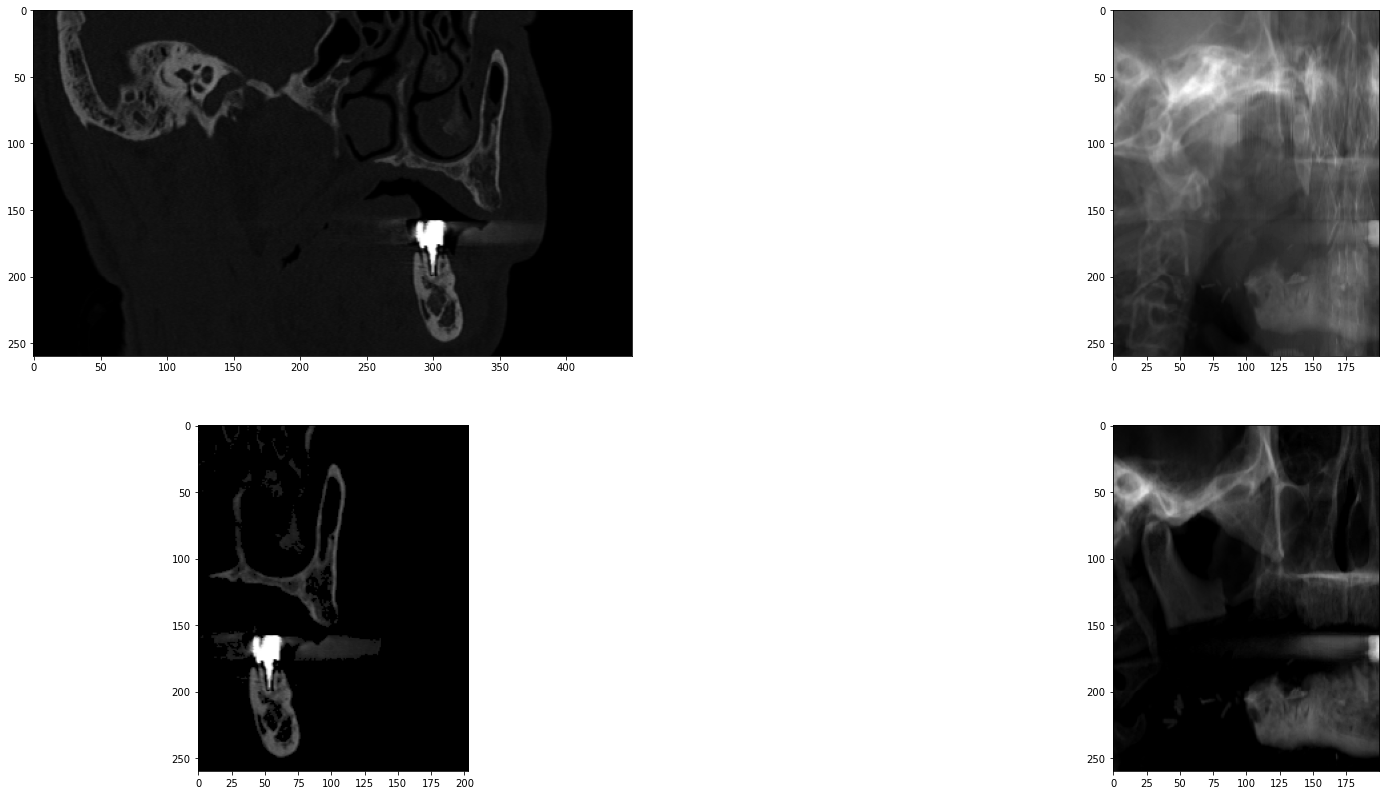

============ 조건 (p>=start_x) ===============
======  220 th =====


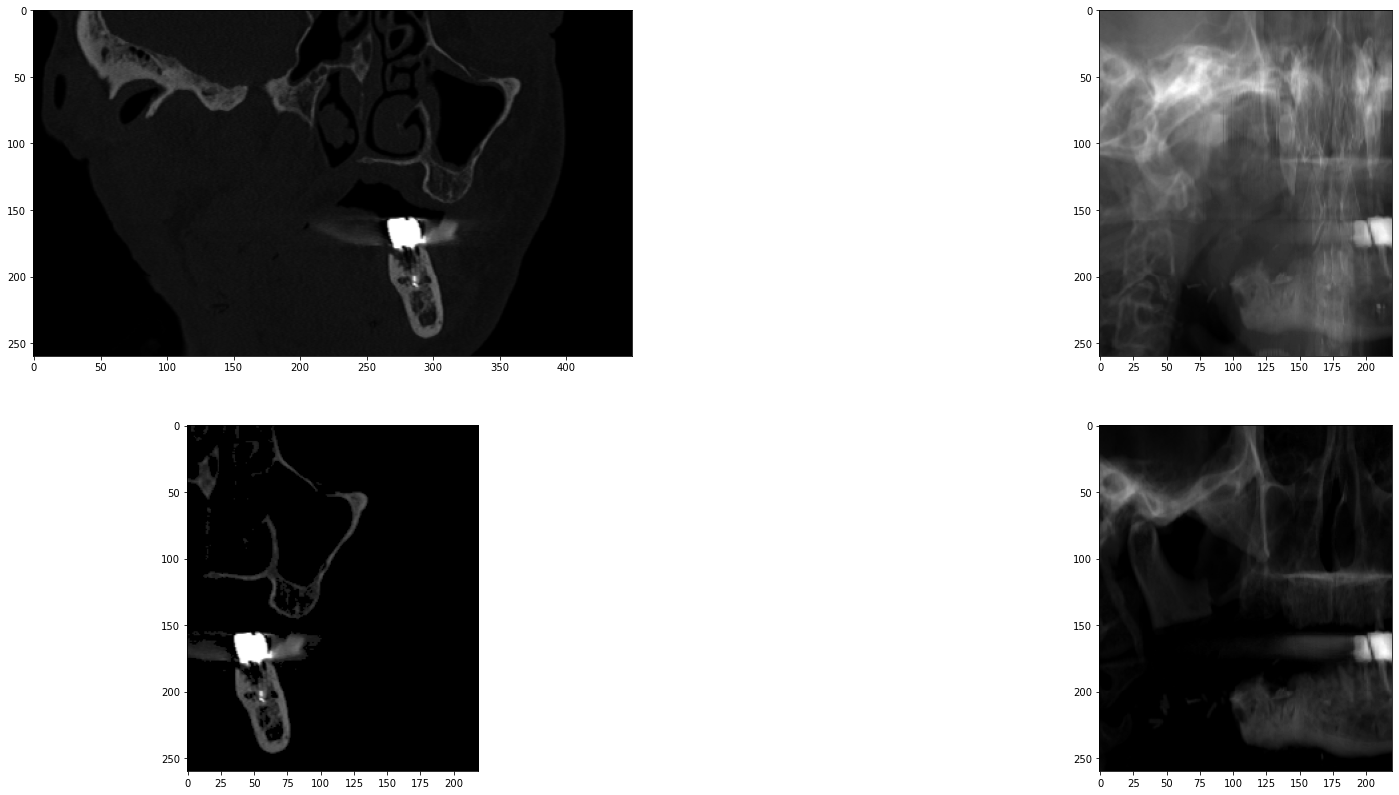

======  240 th =====


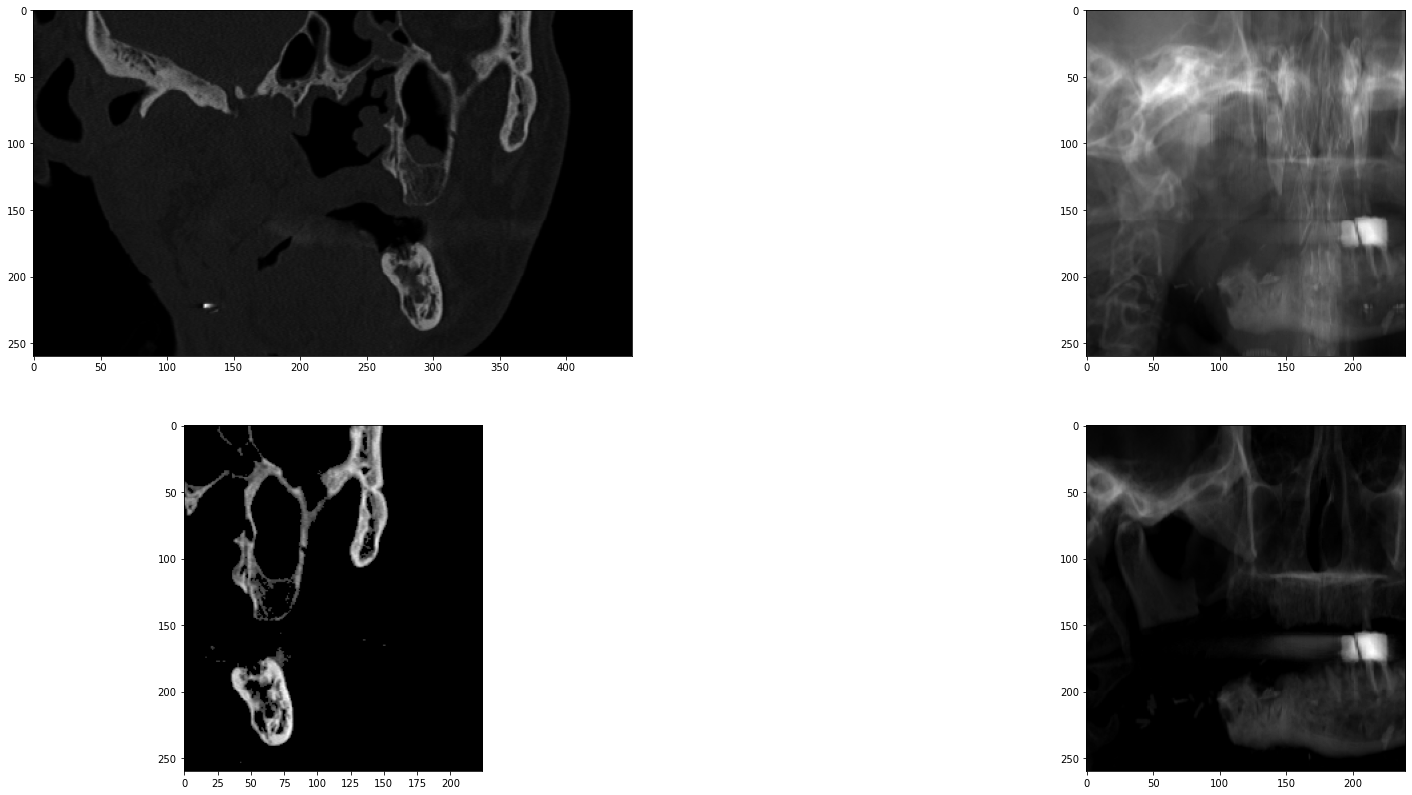

======  260 th =====


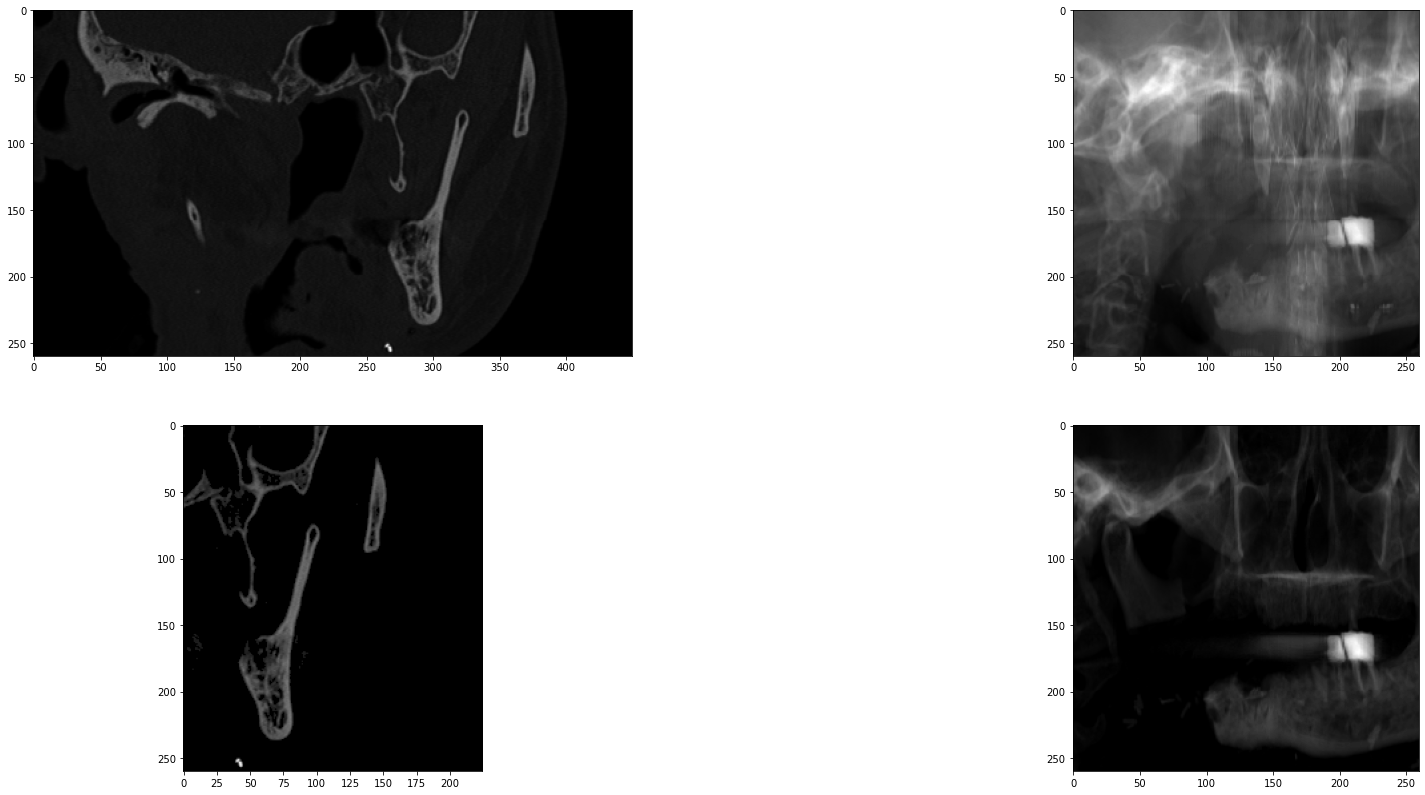

======  280 th =====


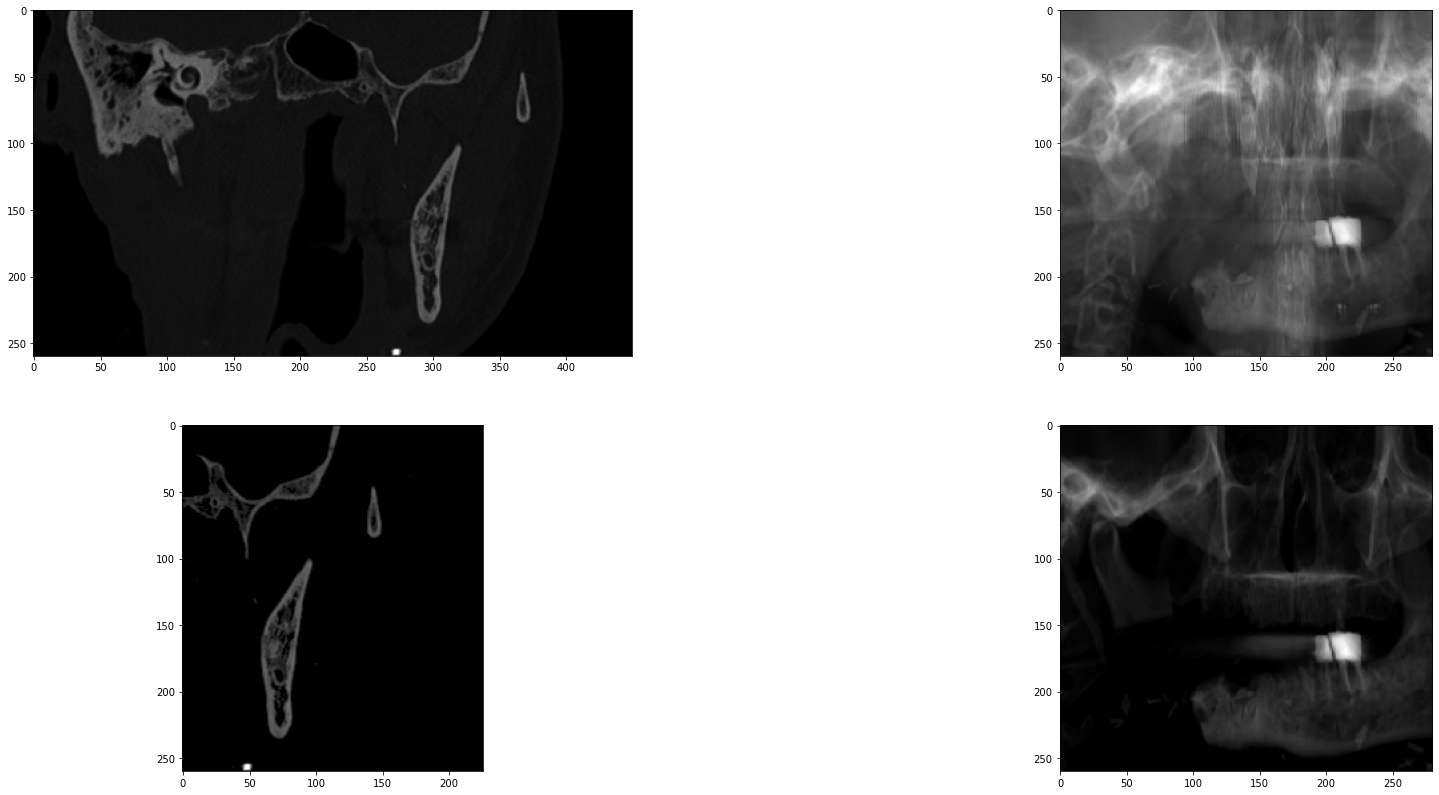

======  300 th =====


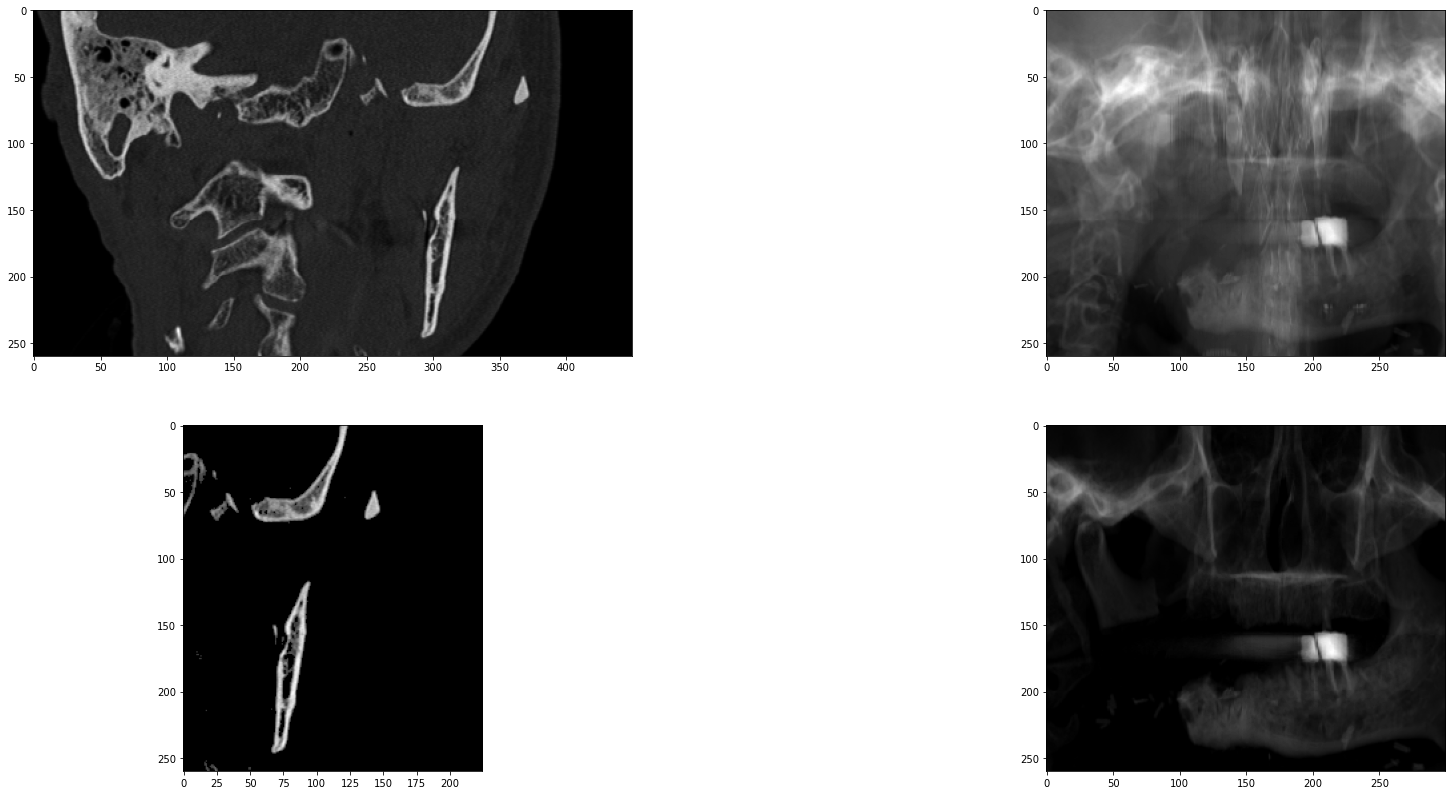

======  320 th =====


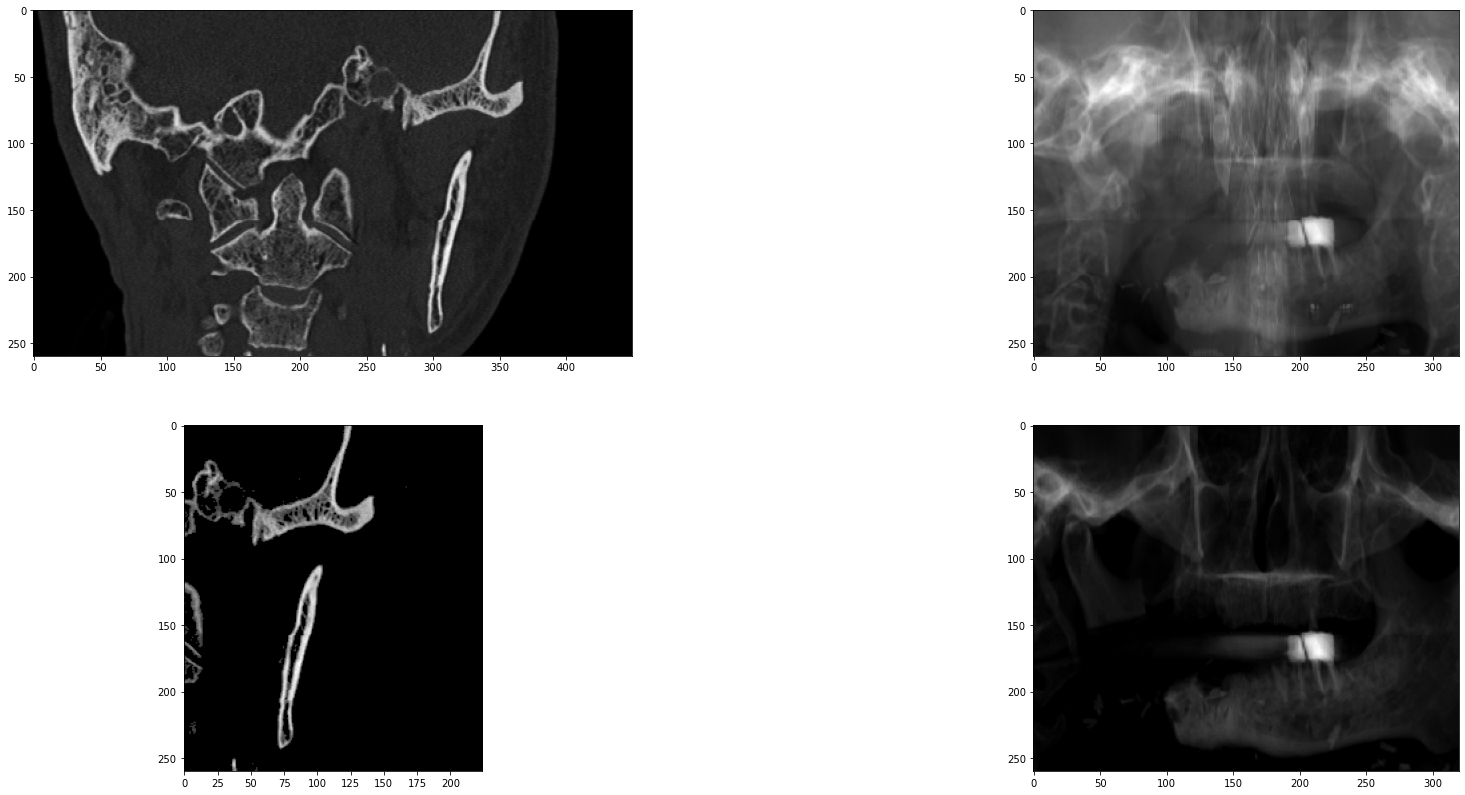

======  340 th =====


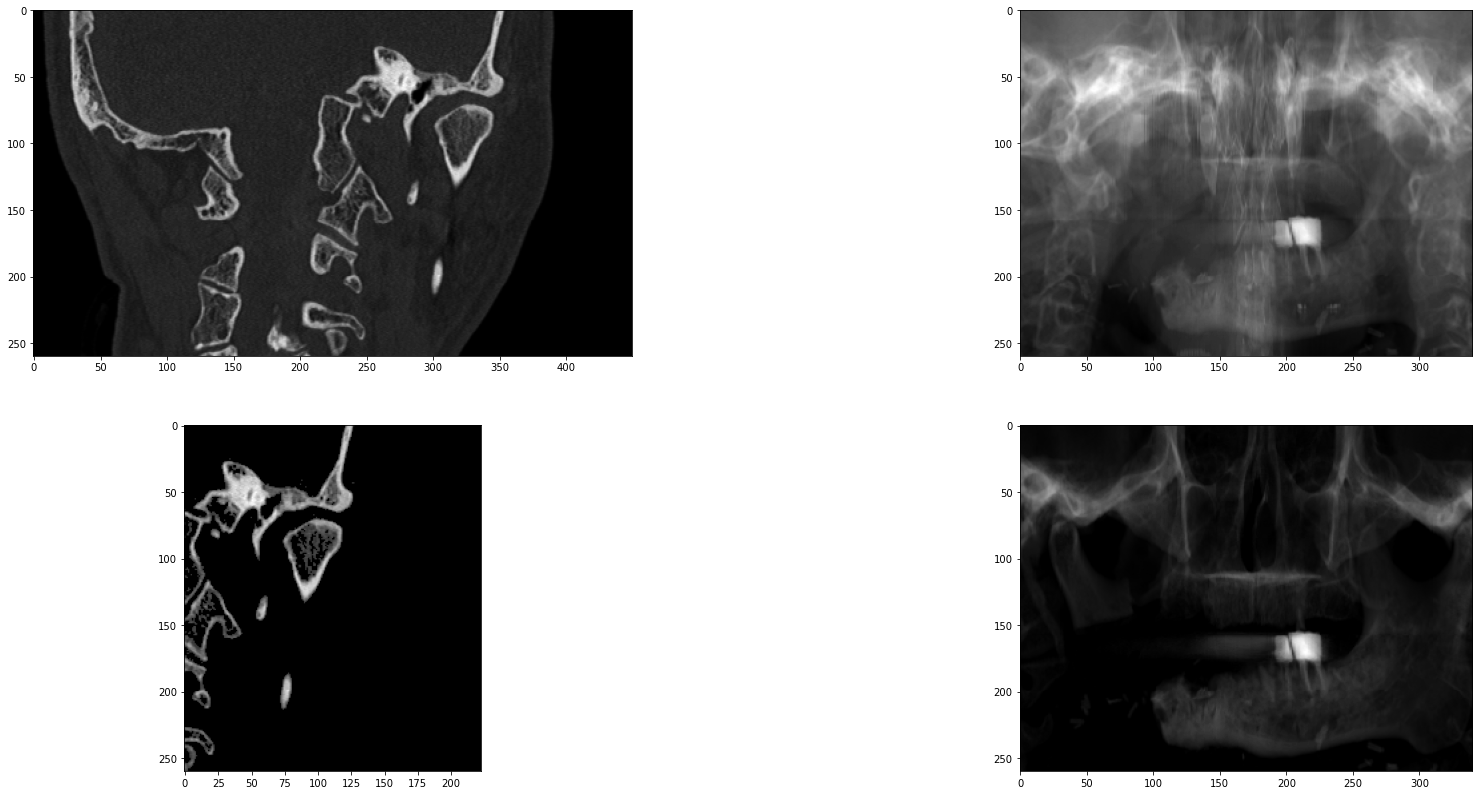

total loop :  37.05412881374359  min
Average  6.280360815888744 sec for 1 loop


In [22]:
######################################### 
## main panoramic system - normal mode ##
#########################################

program_starts = time.time()
# 포물선 꼭지점 좌표 0.015, 245, 330, 190
a = 0.015
b = 245
c = 330
start_x = 170
range_p = 60


sum_ = np.sum(res1, axis=2)

p=start_x
q=round(math.sqrt((-p+c)/a)+b) 
# x와 y 변화량
delta_x = 1
delta_y = 0

i=1
# 반복문(image slicing)
while (p <= c) and (delta_x >= delta_y) :
    loop_starts = time.time()

    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    line = np.zeros((sum_.shape[0], sum_.shape[1]))
    line[q-1, p-1] = 100
    rot_line = rot3d(line, angle, axes=(1,0), reshape=False, prefilter=False)
    rot_point = np.where(rot_line==rot_line.max())
    
    n_slice1 = rot3d(res1, angle, axes=(1,0), reshape=False, prefilter=False)[:, rot_point[1][0], :]
    n_slice2 = np.where(n_slice1<5.7E-01, 0, n_slice1)

    if i != 1 :
        pano1 = np.concatenate((pano1, (np.sum(n_slice1, axis=0)[np.newaxis, ...])), axis=0)
        pano2 = np.concatenate((pano2, (np.sum(n_slice2[:rot_point[0][0]+range_p , :], axis=0)[np.newaxis, ...])), axis=0)
    else:
        pano1 = (np.sum(n_slice1, axis=0)[np.newaxis, ...])
        pano2 = (np.sum(n_slice2[:rot_point[0][0]+range_p , :], axis=0)[np.newaxis, ...])
        
    prev_p=p
    prev_q=q
    p=p+1
    q=round(math.sqrt(-(p-c)/a)+b)
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    
#     plt.figure(figsize=(8,8))
#     plt.axis("off")
#     plt.imshow(rot_line, cmap='gray')
#     plt.show()
    if i%20==0 :   
        print('====== ', i, 'th =====')
        plt.figure(figsize=(30, 14))
        plt.subplot(221)
        plt.imshow(np.fliplr(np.rot90(n_slice1)), cmap='gray')

        plt.subplot(222)
        plt.imshow(np.rot90(pano1), cmap='gray')
        
        plt.subplot(223)
        plt.imshow(np.fliplr(np.rot90(n_slice1[:rot_point[0][0]+range_p , :])), cmap='gray')
        
        plt.subplot(224)
        plt.imshow(np.rot90(pano2), cmap='gray')
        plt.pause(0.05)

    i+=1
    #time for 1 loop
    if i <= 5 : 
        now = time.time()
        print("Takes {0} seconds for 1 loop".format(now - loop_starts))
        
    plt.show()

opp_q = (b*2)-q
print('q : ', q, 'opp_q : ', opp_q)

print("=================== 조건 q>=b =======================")

while (q>=b):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    line = np.zeros((sum_.shape[0], sum_.shape[1]))
    line[q-1, p-1] = 100
    rot_line = rot3d(line, angle, axes=(1,0), reshape=False, prefilter=False)
    rot_point = np.where(rot_line==rot_line.max())
    
    n_slice1 = rot3d(res1, angle, axes=(1,0), reshape=False, prefilter=False)[:, rot_point[1][0], :]

    n_slice2 = np.where(n_slice1<5.7E-01, 0, n_slice1)
        
    pano1 = np.concatenate((pano1, (np.sum(n_slice1, axis=0)[np.newaxis, ...])), axis=0)
    pano2 = np.concatenate((pano2, (np.sum(n_slice2[:rot_point[0][0]+range_p , :], axis=0)[np.newaxis, ...])), axis=0)
    
    prev_p=p
    prev_q=q
    q= round(q-1)
    p= round(-a*(q-b)**2+c)
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
        
    if i%20==0 :   
        print('====== ', i, 'th =====')
        plt.figure(figsize=(30, 14))
        plt.subplot(221)
        plt.imshow(np.fliplr(np.rot90(n_slice1)), cmap='gray')

        plt.subplot(222)
        plt.imshow(np.rot90(pano1), cmap='gray')
        
        plt.subplot(223)
        plt.imshow(np.fliplr(np.rot90(n_slice2[:rot_point[0][0]+range_p , :])), cmap='gray')
        
        plt.subplot(224)
        plt.imshow(np.rot90(pano2), cmap='gray')
        plt.pause(0.05)
        
    i+=1
    plt.show()

print("============ 조건 (q>=opp_q) and (delta_x<=delta_y) ===============")

while (q>=opp_q) and (delta_x<=delta_y):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    line = np.zeros((sum_.shape[0], sum_.shape[1]))
    line[q-1, p-1] = 100
    rot_line = rot3d(line, angle, axes=(1,0), reshape=False, prefilter=False)
    rot_point = np.where(rot_line==rot_line.max())
    
    n_slice1 = rot3d(res1, angle, axes=(1,0), reshape=False, prefilter=False)[:, rot_point[1][0], :]

    n_slice2 = np.where(n_slice1<5.7E-01, 0, n_slice1)
        
    pano1 = np.concatenate((pano1, (np.sum(n_slice1, axis=0)[np.newaxis, ...])), axis=0)
    pano2 = np.concatenate((pano2, (np.sum(n_slice2[:rot_point[0][0]+range_p , :], axis=0)[np.newaxis, ...])), axis=0)

    prev_p=p
    prev_q=q
    q=round(q-1)
    p=round(-a*(-q+b)**2+c)
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
        
    if i%20==0 :   
        print('====== ', i, 'th =====')
        plt.figure(figsize=(30, 14))
        plt.subplot(221)
        plt.imshow(np.fliplr(np.rot90(n_slice1)), cmap='gray')

        plt.subplot(222)
        plt.imshow(np.rot90(pano1), cmap='gray')
        
        plt.subplot(223)
        plt.imshow(np.fliplr(np.rot90(n_slice2[:rot_point[0][0]+range_p , :])), cmap='gray')
        
        plt.subplot(224)
        plt.imshow(np.rot90(pano2), cmap='gray')
        plt.pause(0.05)
    
    i+=1
    plt.show()
    
print("============ 조건 (p>=start_x) ===============")

while (p>=start_x):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    line = np.zeros((sum_.shape[0], sum_.shape[1]))
    line[q-1, p-1] = 100
    rot_line = rot3d(line, angle, axes=(1,0), reshape=False, prefilter=False)
    rot_point = np.where(rot_line==rot_line.max())
    
    n_slice1 = rot3d(res1, angle, axes=(1,0), reshape=False, prefilter=False)[:, rot_point[1][0], :]

    n_slice2 = np.where(n_slice1<5.7E-01, 0, n_slice1)
      
    pano1 = np.concatenate((pano1, (np.sum(n_slice1, axis=0)[np.newaxis, ...])), axis=0)
    pano2 = np.concatenate((pano2, (np.sum(n_slice2[:rot_point[0][0]+range_p , :], axis=0)[np.newaxis, ...])), axis=0)
    
    prev_p=p
    prev_q=q
    p=p-1 
    q=round(-math.sqrt(-(p-c)/a)+b)
    
    if i%20==0 :   
        print('====== ', i, 'th =====')
        plt.figure(figsize=(30, 14))
        plt.subplot(221)
        plt.imshow(np.fliplr(np.rot90(n_slice1)), cmap='gray')

        plt.subplot(222)
        plt.imshow(np.rot90(pano1), cmap='gray')
        
        plt.subplot(223)
        plt.imshow(np.fliplr(np.rot90(n_slice2[:rot_point[0][0]+range_p , :])), cmap='gray')
        
        plt.subplot(224)
        plt.imshow(np.rot90(pano2), cmap='gray')
        plt.pause(0.05)
    
    i+=1
    plt.show()

now = time.time()
tot_time = now - program_starts
print("total loop : ",(tot_time/60), " min")
print("Average ", (tot_time/i), "sec for 1 loop")

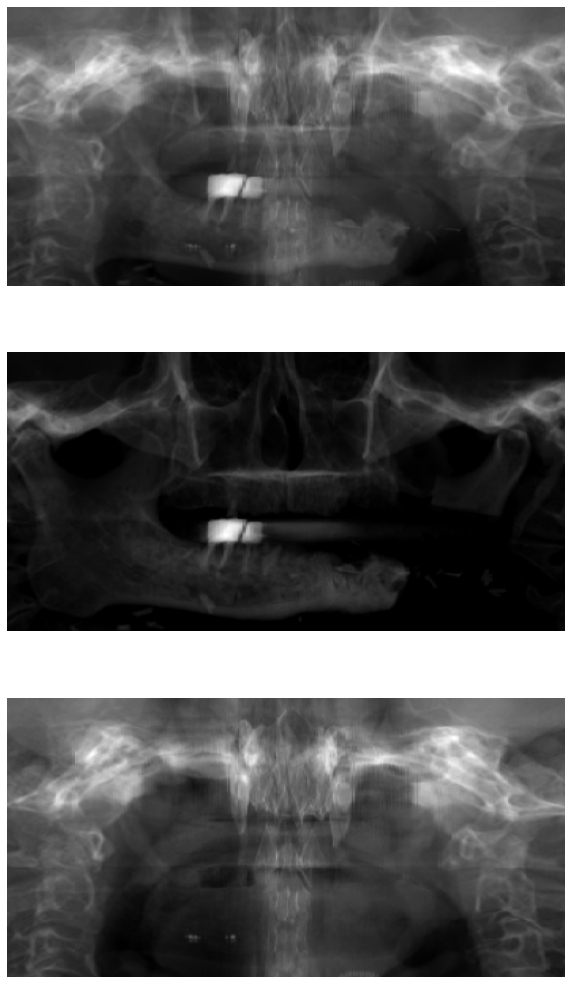

In [23]:
a = cv2.resize(np.fliplr(np.rot90(pano1)), dsize=(500, 250), interpolation=cv2.INTER_AREA)
c = cv2.resize(np.fliplr(np.rot90(pano2)), dsize=(500, 250), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10,18))
plt.subplot(311)
plt.axis('off')
plt.imshow(a, cmap='gray')

plt.subplot(312)
plt.axis('off')
plt.imshow(c, cmap='gray')   

plt.subplot(313)
plt.axis('off')
plt.imshow(a-c, cmap='gray')  

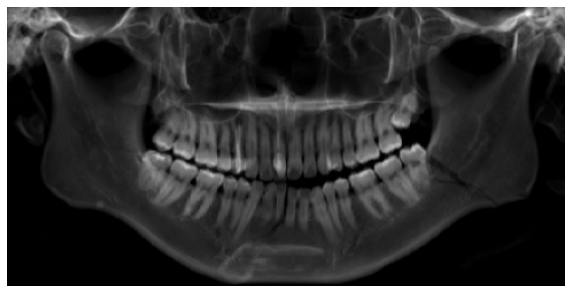

In [37]:
plt.figure(figsize=(10,9))
# plt.subplot(311)
plt.axis('off')
plt.imshow(c, cmap='gray')
plt.show()
# plt.subplot(312)
# plt.axis('off')
# plt.imshow(b, cmap='gray')  

100


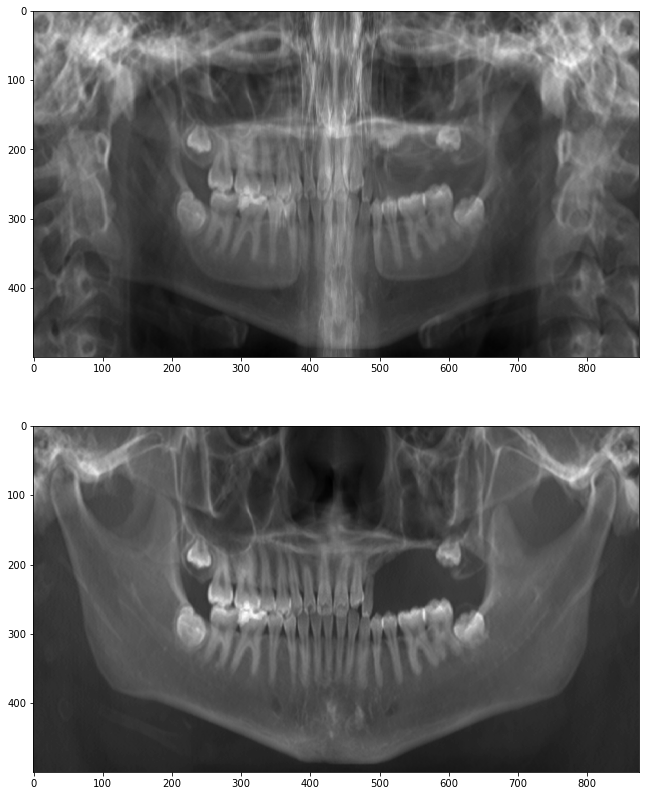

In [33]:
print(range_p)
plt.figure(figsize=(20, 14))

plt.subplot(211)
plt.imshow(np.rot90(pano1), cmap='gray')

plt.subplot(212)
plt.imshow(np.rot90(pano2), cmap='gray')